# Introduction to `tinygp`

This tutorial gives a quick intro to `tinygp` and, in particular, the scalable solver that exploits quasiseparable structure.

## Setup

First, to get things to work on Google Colab, we'll need to install a few dependencies that are not already available on Colab. If you're running locally, it's probably better to install these dependencies (and JAX) yourself, however you prefer.

In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp    
    
try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt

/opt/homebrew/Caskroom/miniforge/base/envs/tinygp/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Like in the intro to JAX tutorial, we want to enable double precision.

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

All the imports that we'll need below:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jaxopt
import jax.numpy as jnp

import tinygp

print(tinygp.__version__)

0.2.0rc2.dev9+gcb8ebb3.d20220304


Let's start be generating some slightly non-trival fake data.
We're going to generate 1000 data points because that's enough to show why scalable methods are very nice, but still doable with traditional methods.

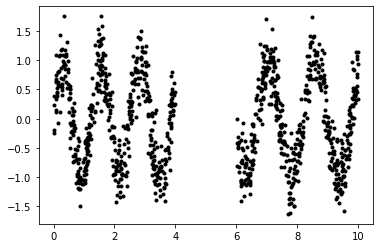

In [4]:
random = np.random.default_rng(1)
x_grid = np.linspace(-2, 12, 1000)
x = np.append(
    np.sort(random.uniform(0, 4, 500)),
    np.sort(random.uniform(6, 10, 500)),
)
yerr = 0.3
y = np.sin(2 * np.pi * x / (1.3 + 0.02 * (x - 5))) + random.normal(0, yerr, size=len(x))
plt.plot(x, y, ".k");

## Making your first `tinygp.GaussianProcess`

You build a GP by constructing a kernel.
You can add, multiply, and scale objects in the `tinygp.kernels` submodule:

In [5]:
kernel = 0.3**2 * tinygp.kernels.Matern32(1.0) * tinygp.kernels.Cosine(1.3)
gp = tinygp.GaussianProcess(kernel, x, diag=yerr**2)
gp.log_probability(y)

DeviceArray(-305.64092748, dtype=float64)

As well as computing the log probability of the model, you can also condition on data and compute the predicted model as follows:

In [6]:
_, cond = gp.condition(y, x_grid)

Unlike some other packages, the conditional distribution for a `tinygp` model is itself another `GaussianProcess` object:

In [7]:
type(cond)

tinygp.gp.GaussianProcess

So you'll access the properties of the conditional GP to plot the predicted values:

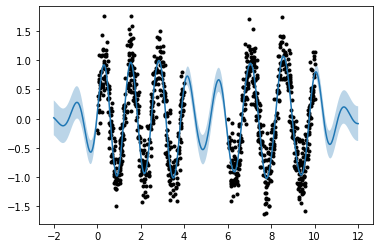

In [8]:
_, cond = gp.condition(y, x_grid)

mu = cond.loc
var = cond.variance
std = np.sqrt(var)

plt.plot(x, y, ".k")
plt.plot(x_grid, mu)
plt.fill_between(x_grid, mu - std, mu + std, alpha=0.3);

## Fitting data

That model isn't bad, but I just made up the parameters, so we can probably do better.
This is the usual boilerplate that you'll need for fitting a GP model to data using `tinygp`:

In [9]:
def build_gp(params):
    kernel = jnp.exp(2*params["log_amp"])
    kernel *= tinygp.kernels.Matern32(jnp.exp(params["log_ell"]))
    kernel *= tinygp.kernels.Cosine(jnp.exp(params["log_period"]))
    return tinygp.GaussianProcess(kernel, x, diag=yerr**2, mean=params["mean"])

@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(y)

params = {
    "log_amp": jnp.log(0.3),
    "log_ell": jnp.log(1.0),
    "log_period": jnp.log(1.3),
    "mean": jnp.zeros(()),
}
loss(params)

DeviceArray(305.64092748, dtype=float64)

Here our loss function is the negative log probability (the negative log marginalized likelihood for the hyperparameters), and let's see how fast it is:

In [10]:
%timeit loss(params).block_until_ready()

12.9 ms ± 871 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On my laptop this costs a little over 10ms (using multiple cores) - not too bad!

We can fit this model by minimizing this loss (or, equivalently, maximizing the likelihood):

In [11]:
%%time
opt = jaxopt.ScipyMinimize(fun=loss)
soln = opt.run(params)
soln.state.fun_val.block_until_ready()

CPU times: user 6.89 s, sys: 1.96 s, total: 8.84 s
Wall time: 1.4 s


DeviceArray(278.39507308, dtype=float64, weak_type=True)

In [12]:
soln.params

{'log_amp': DeviceArray(-0.16082259, dtype=float64),
 'log_ell': DeviceArray(1.79462686, dtype=float64),
 'log_period': DeviceArray(0.33609909, dtype=float64),
 'mean': DeviceArray(0.00533429, dtype=float64)}

Plot the conditional model for our optimized model:

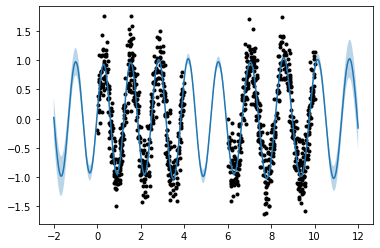

In [13]:
_, cond = build_gp(soln.params).condition(y, x_grid)

mu = cond.loc
var = cond.variance
std = np.sqrt(var)

plt.plot(x, y, ".k")
plt.plot(x_grid, mu)
plt.fill_between(x_grid, mu - std, mu + std, alpha=0.3);

## Scalable computations

The whole point of this session is to demonstrate the scalable method that `tinygp` includes.
To enable the quasiseparable solver, it is sufficient to swap out the kernel for one implemented entirely using kernels defined in `tinygp.kernels.quasisep`.
I chose kernels that already exist there, so things don't change much:

In [14]:
def build_gp_quasisep(params):
    kernel = jnp.exp(2*params["log_amp"])
    kernel *= tinygp.kernels.quasisep.Matern32(jnp.exp(params["log_ell"]))
    kernel *= tinygp.kernels.quasisep.Cosine(jnp.exp(params["log_period"]))
    return tinygp.GaussianProcess(kernel, x, diag=yerr**2, mean=params["mean"])

@jax.jit
def loss_quasisep(params):
    gp = build_gp_quasisep(params)
    return -gp.log_probability(y)

loss_quasisep(params)

DeviceArray(305.64092748, dtype=float64)

Let's benchmark this version:

In [15]:
%timeit loss_quasisep(params).block_until_ready()

337 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


🔥

Now we can minimize the loss as before.
We should get exactly the same result in significantly less time.

In [16]:
%%time
opt_quasisep = jaxopt.ScipyMinimize(fun=loss_quasisep)
soln_quasisep = opt_quasisep.run(params)
soln_quasisep.state.fun_val.block_until_ready()

CPU times: user 781 ms, sys: 19 ms, total: 800 ms
Wall time: 800 ms


DeviceArray(278.39507308, dtype=float64, weak_type=True)

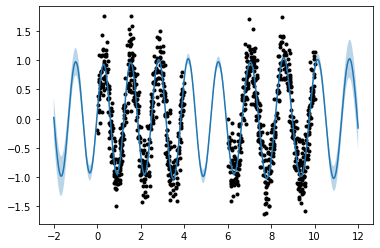

In [17]:
_, cond = build_gp_quasisep(soln_quasisep.params).condition(y, x_grid)

mu = cond.loc
var = cond.variance
std = np.sqrt(var)

plt.plot(x, y, ".k")
plt.plot(x_grid, mu)
plt.fill_between(x_grid, mu - std, mu + std, alpha=0.3);

## Suggested exercises

1. Add a "jitter" parameter (you'll probably want to use `log(jitter)` as your paramter, since jitter must be positive) to the model that gets added in quadrature to the diagonal of the covariance matrix.

2. Try out some different kernels (check out [the tinygp docs](https://tinygp.readthedocs.io) for some examples) and different initial parameter guesses. What are some good and/or bad choices? How might you choose which one you want to use? As you build more or less complicated kernels, how does the relative performance of the default solver and quasiseparable solver compare?

3. We often want to marginalize over the hyperparameters instead of just optimizing them. One common method for doing this marginalization is Markov chain Monte Carlo (MCMC). The `tinygp` docs include a tutorial demonstrating the use of `numpyro` for MCMC with a `tinygp` model. Use that tutorial as a template and implement MCMC for this model.

4. Try fitting a `tinygp` model to your favorite RV dataset (perhaps one without a known planet?). Do you get any benefit from the quasiseparable solver in this case? What would you need if you wanted to fit a system with a known planet or two?